<a href="https://colab.research.google.com/github/ivy3150/RNN-Text-Tweet-Classification/blob/main/8_TweetClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Text: Tweet Classification
**OPIM 5509: Introduction to Deep Learning - University of Connecticut**


*   Full Name: Ping-Hsuan Chiang
*   Link to data: https://drive.google.com/drive/folders/1BvKF7Ui4XLtwV0LHFWmOKqsouxbjvnWZ?usp=sharing


-----------------------------------------------
This assignment is to apply text classification to a real-world problem. First, a function to scrape tweets of certain users on Twitter was provided. Next, I chose any two people you are interested in and used the function to scrape the 2000 tweets for each person. Then save these tweets to my own drive as text files with two folders.

#Table of contents

**Part I: Data Preparation**
* Motivations
* Use the function to scrape 2000 tweets from each person/organization and save to the drive.
* Load the data from the drive. 
* Tokenize, pad the sequences and split data to training and validation. 

**Part II: Modeling**
* Fit three models with different architectures of varying complexity. Can select:
  * LSTM, GRU or SimpleRNN
  * Bidirectional LSTM or GRU
  * 1D Conv and Pooling
  * Pre-loaded word embeddings (i.e. GLOVE)
  * All of the above with stacked layers etc.

* For each model you built, make a confusion matrix with report (like this: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

**Tip:** If getting bad accuracy, try to change the max length and most common words, this can make a difference sometimes. Do not worry about accuracy from the first model, just try to improve it in subsequent models.

**Part III: Analysis**
* Compare the results and discuss how to improve the models by changing the architectures.


# Part I: Data Prep


*   Motivations: I am interested in Paris Hilton and Kim Kardashian because I am curious about them after reading the stories between them and watching the video that Uncle Roger (Nigel Ng) commented about the first episode of Cooking with Paris featuring Kim. The video was very funny, and I am also curious about other people's comments. Though they look friendly to each other and Kim also attended Paris's wedding, the friendship still looks somewhat fake. The two people have got a lot of media coverage for over 14 years! I am sure that you are also curious about their friendship, their chemistry, and what other people talked about them.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# make a folder to store data
base_dir = '/content/drive/MyDrive/5509 Deep Learning/Module 5/5.2 Assignment/Data'

import tensorflow as tf

#Create a new directory (a folder) in your Drive
tf.io.gfile.mkdir(base_dir)

#Combine the 2 strings
hilton_dir = base_dir + '/Hilton/'

#Create the second directory
tf.io.gfile.mkdir(hilton_dir)

#Combine the 2 strings
kardashian_dir = base_dir + '/Kardashian/'

#Create the second directory
tf.io.gfile.mkdir(kardashian_dir)

In [ ]:
!pip install snscrape
import snscrape.modules.twitter as sntwitter
import csv

In [ ]:
#Hilton
maxTweets = 2000

# make sure you update the username and number of tweets!
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@ParisHilton + since:2015-12-02 until:2021-11-14-filter:links -filter:replies').get_items()):
  csvFile = open(hilton_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

In [ ]:
#Kardashian
maxTweets = 2000

# make sure you update the username and number of tweets!
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@KimKardashian + since:2015-12-02 until:2021-11-14-filter:links -filter:replies').get_items()):
  csvFile = open(kardashian_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

## Load data and prepare data for modeling

In [ ]:
#Load the data you just saved from your drive
import os

my_dir = base_dir

labels = []
texts = []
count = 0
for label_type in ['Hilton/', 'Kardashian/']:
    dir_name = os.path.join(my_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.csv':
            count = count + 1
            print(count)
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'Hilton/':
                labels.append(0)
            else:
                labels.append(1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# Tokenize, pad and prepare training and validation data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 200 # or 200
validation_samples = 1000  # We will be validating on 1000 samples
max_words = 2000  # We will only consider the top 1000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)

# fit_on_texts means it learns the indices of the words
tokenizer.fit_on_texts(texts)

# the sequences are comprised of those indices
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# in case of low word counts, we need to pad sequences
# so that they are uniform length
data = pad_sequences(sequences, maxlen=maxlen)

# our labels, which were previously stored as a list [],
# are now converted to a numpy array for modeling
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 15769 unique tokens.
Shape of data tensor: (4004, 200)
Shape of label tensor: (4004,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 3000  # We will be training on 3000 samples

x_train = data[:training_samples] # from 0 to training samples
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3000, 200) (3000,)
(1000, 200) (1000,)


# Part II: Modeling





## Model 1:

*   Pre-loaded word embeddings 
*   MaxPooling 1D
*   GRU

In [ ]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, GRU, MaxPool1D

model = Sequential()
model.add(Embedding(max_words, 10, input_length=maxlen))
model.add(MaxPool1D(2))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.1))
# recurrent dropout turns off 10% of the weights in this cell to slow down the training of the model 
# and to explore more aspects of the network
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 10)            10000     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 10)           0         
 1D)                                                             
                                                                 
 gru_4 (GRU)                 (None, 64)                14592     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26,705
Trainable params: 26,705
Non-trainable params: 0
__________________________________________________

In [ ]:
# Run the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
300/300 [==============================] - 8s 21ms/step - loss: 0.4973 - acc: 0.7273 - val_loss: 0.2987 - val_acc: 0.8710
Epoch 2/10
300/300 [==============================] - 6s 19ms/step - loss: 0.2135 - acc: 0.9123 - val_loss: 0.2646 - val_acc: 0.8900
Epoch 3/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1565 - acc: 0.9403 - val_loss: 0.2805 - val_acc: 0.8810
Epoch 4/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1263 - acc: 0.9500 - val_loss: 0.3209 - val_acc: 0.8770
Epoch 5/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1040 - acc: 0.9603 - val_loss: 0.3393 - val_acc: 0.8820
Epoch 6/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0903 - acc: 0.9670 - val_loss: 0.3417 - val_acc: 0.8850
Epoch 7/10
300/300 [==============================] - 6s 19ms/step - loss: 0.0985 - acc: 0.9667 - val_loss: 0.3268 - val_acc: 0.8900
Epoch 8/10
300/300 [==============================] - 6s 19ms/step - 

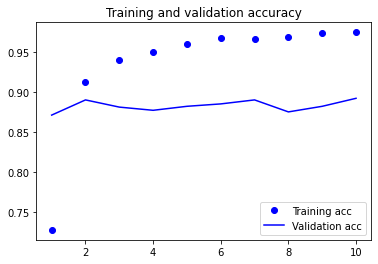

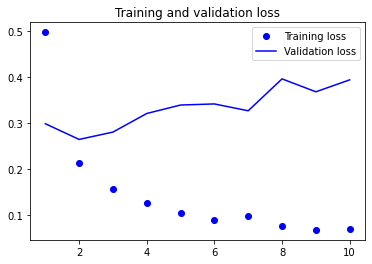

In [ ]:
# Learning Curve for the model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# classification report and confusion matrix
from sklearn.metrics import confusion_matrix

# see how the model did!
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
preds = np.round(model.predict(x_val),0)
preds[0]

array([0.], dtype=float32)

In [ ]:
# confusion matrix (tough to see... but most is on diagonal!)
matrix = confusion_matrix(y_val, preds)
matrix

array([[439,  55],
       [ 53, 453]])

In [ ]:
# classification report 
from sklearn.metrics import classification_report

# more detail on how well things were predicted
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       494
           1       0.89      0.90      0.89       506

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



## Model 2:

*   Pre-loaded word embeddings 
*   Conv1D
*   Bidirectional GRU
*   LSTM

In [ ]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, GRU, Bidirectional, Conv1D

model = Sequential()
model.add(Embedding(max_words, 12, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(Bidirectional(GRU(70,
                            return_sequences=True, # remember, if stacking layers, you need to return sequences!
                            activation='relu',
                            recurrent_dropout=0.2)))
model.add(LSTM(70, dropout=0.1, recurrent_dropout=0.2))
# recurrent dropout turns off 20% of the weights in this cell to slow down the training of the model 
# and to explore more aspects of the network
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 12)            12000     
                                                                 
 conv1d (Conv1D)             (None, 48, 128)           4736      
                                                                 
 bidirectional_2 (Bidirectio  (None, 48, 140)          84000     
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 70)                59080     
                                                                 
 dense_2 (Dense)             (None, 30)                2130      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                      

In [ ]:
# Run the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/15
300/300 [==============================] - 52s 159ms/step - loss: 0.4432 - acc: 0.7597 - val_loss: 0.3484 - val_acc: 0.8590
Epoch 2/15
300/300 [==============================] - 48s 159ms/step - loss: 0.2189 - acc: 0.9070 - val_loss: 0.3322 - val_acc: 0.8750
Epoch 3/15
300/300 [==============================] - 47s 156ms/step - loss: 0.1632 - acc: 0.9373 - val_loss: 0.3210 - val_acc: 0.8790
Epoch 4/15
300/300 [==============================] - 47s 157ms/step - loss: 0.1546 - acc: 0.9367 - val_loss: 0.3527 - val_acc: 0.8810
Epoch 5/15
300/300 [==============================] - 47s 156ms/step - loss: 0.1192 - acc: 0.9573 - val_loss: 0.3679 - val_acc: 0.8740
Epoch 6/15
300/300 [==============================] - 47s 156ms/step - loss: 0.1080 - acc: 0.9600 - val_loss: 0.3171 - val_acc: 0.8990
Epoch 7/15
300/300 [==============================] - 47s 156ms/step - loss: 0.1008 - acc: 0.9647 - val_loss: 0.3393 - val_acc: 0.8790
Epoch 8/15
300/300 [==============================] - 4

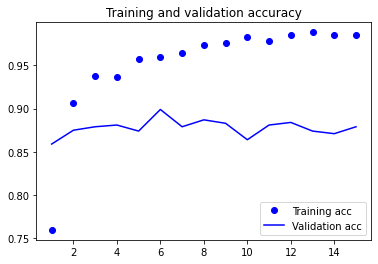

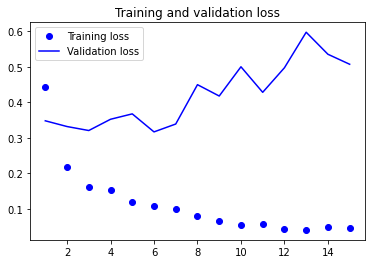

In [ ]:
# Learning Curve for the model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# classification report and confusion matrix
from sklearn.metrics import confusion_matrix

# see how the model did!
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
preds = np.round(model.predict(x_val),0)
preds[0]

array([0.], dtype=float32)

In [ ]:
# confusion matrix (tough to see... but most is on diagonal!)
matrix = confusion_matrix(y_val, preds)
matrix

array([[436,  58],
       [ 63, 443]])

In [ ]:
# classification report 
from sklearn.metrics import classification_report

# more detail on how well things were predicted
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       494
           1       0.88      0.88      0.88       506

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



## Model 3:

*   Pre-loaded word embeddings 
*   Conv1D
*   MaxPooling 1D
*   Bidirectional LSTM
*   GRU

In [ ]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPool1D

model = Sequential()
model.add(Embedding(max_words, 12, input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=3))
model.add(MaxPool1D(2))
model.add(Bidirectional(LSTM(70,
                            return_sequences=True, # remember, if stacking layers, you need to return sequences!
                            activation='relu',
                            recurrent_dropout=0.3)))
model.add(GRU(70, dropout=0.2, recurrent_dropout=0.3))
# recurrent dropout turns off 30% of the weights in this cell to slow down the training of the model 
# and to explore more aspects of the network
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 200, 12)           24000     
                                                                 
 conv1d_10 (Conv1D)          (None, 198, 128)          4736      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_12 (Bidirecti  (None, 99, 140)          111440    
 onal)                                                           
                                                                 
 gru_15 (GRU)                (None, 70)                44520     
                                                                 
 dense_22 (Dense)            (None, 30)              

In [ ]:
# Run the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
300/300 [==============================] - 97s 307ms/step - loss: 0.3982 - acc: 0.7900 - val_loss: 0.2059 - val_acc: 0.9120
Epoch 2/10
300/300 [==============================] - 92s 305ms/step - loss: 0.1924 - acc: 0.9310 - val_loss: 0.2010 - val_acc: 0.9210
Epoch 3/10
300/300 [==============================] - 92s 305ms/step - loss: 0.1134 - acc: 0.9577 - val_loss: 0.2443 - val_acc: 0.9110
Epoch 4/10
300/300 [==============================] - 92s 308ms/step - loss: 0.1188 - acc: 0.9543 - val_loss: 0.2511 - val_acc: 0.9010
Epoch 5/10
300/300 [==============================] - 92s 306ms/step - loss: 0.0929 - acc: 0.9613 - val_loss: 0.2447 - val_acc: 0.9110
Epoch 6/10
300/300 [==============================] - 92s 307ms/step - loss: 0.0982 - acc: 0.9653 - val_loss: 0.2460 - val_acc: 0.9080
Epoch 7/10
300/300 [==============================] - 92s 308ms/step - loss: 0.0788 - acc: 0.9707 - val_loss: 0.2770 - val_acc: 0.9220
Epoch 8/10
300/300 [==============================] - 9

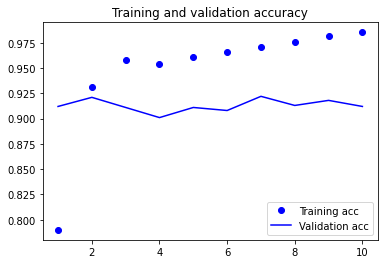

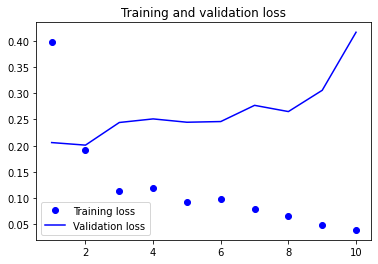

In [ ]:
# Learning Curve for the model
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# classification report and confusion matrix
from sklearn.metrics import confusion_matrix

# see how the model did!
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
preds = np.round(model.predict(x_val),0)
preds[0]

array([0.], dtype=float32)

In [ ]:
# confusion matrix (tough to see... but most is on diagonal!)
matrix = confusion_matrix(y_val, preds)
matrix

array([[458,  36],
       [ 52, 454]])

In [ ]:
# classification report 
from sklearn.metrics import classification_report

# more detail on how well things were predicted
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       494
           1       0.93      0.90      0.91       506

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



#Part III: Analysis

*   The performance of Model 1 is not bad. The overall accuracy is 89% though it appeared overfitting. 
*   For Model 2, I added the bidirectional layer and raised the recurrent dropouts a little bit to improve the performance. However, the accuracy dropped 1%. 
*   For the first attempt of Model 3, I tried to create a monster model, namely a combination of Model 1 and Model 2. Model 3 has a bidirectional LSTM layer and a GRU layer while Model 2 has a bidirectional GRU layer and a LSTM layer. Additionally, I raised the recurrent dropouts to 30%. The overall accuracy is 90%, so the performance improved! 
*   For the second attempt of Model 3, I tried to change the max length from 50 to 100 and the most common words from 1000 to 2000. The overall accuracy is 92%, so the performance improved again!
*   For the last attempt of Model 3, I changed the max length to 200. The overall accuracy is 91%, so the change did not help the improvement.
*   In conclusion, changing the max length and the most common words slightly improved the accuracy. Since both the max length and the most common words increased, the time of running the model became longer. In addition, Model 3 with the stacked layers improved the performance. Increasing the recurrent dropouts can also help turn off the noise. 




# Appendix:
### Find top 50 words for each person

In [ ]:
# Find top 50 words for each person
labels_ = []
texts_ = []
count = 0
for label_type in ['Hilton/', 'Kardashian/']:
    dir_name = os.path.join(my_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.csv':
            count = count + 1
            f = open(os.path.join(dir_name, fname))
            texts_.append(f.read())
            f.close()
            if label_type == 'Hilton/':
                labels_.append('Hilton')
            else:
                labels_.append('Kardashian')

In [ ]:
import pandas as pd
dic={'Label':labels_,'Text':texts_}
df=pd.DataFrame(dic)
df_hilton=df[df.Label=='Hilton']
df_kardashian=df[df.Label=='Kardashian']

In [ ]:
# before removing the stop words
a=pd.Series(' '.join(df_hilton.Text).split()).value_counts()[:50]
b=pd.Series(' '.join(df_kardashian.Text).split()).value_counts()[:50]

In [ ]:
# the top 50 words for each person are not helpful for the text analysis
a_=pd.DataFrame(a,columns=['Hilton'])
b_=pd.DataFrame(b,columns=['Kardashian'])
print(a_)
print(b_)

               Hilton
id,date,tweet    2002
to               1103
the               869
my                855
you               705
and               670
for               528
of                502
I                 479
a                 464
in                464
with              417
on                417
so                370
your              289
is                284
&amp;             257
this              241
at                238
be                227
all               205
love              201
me                187
-                 186
🥰                 185
new               177
#MakeAWish        171
it                147
are               140
that              134
😍                 118
have              110
by                104
So                104
excited           103
link              101
about             100
Thank              99
much               92
Love               89
out                89
was                88
proud              82
will               81
more      

In [ ]:
c=pd.concat([a_,b_],axis=1,join='outer',ignore_index=False)
c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, id,date,tweet to over
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hilton      50 non-null     float64
 1   Kardashian  50 non-null     float64
dtypes: float64(2)
memory usage: 1.6+ KB


In [ ]:
# let's remove some of the stop words (see what happens if you comment this cell out)
# we can do better!
# define some stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') # this makes sure these are downloaded if you haven't already!
print(stopwords.words('english'))

stop = stopwords.words('english') # see why it's important to turn everything lower case? all of your stopwords are!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [ ]:
# remove the stop words
a=pd.Series(' '.join(df_hilton.Text).split()).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) .value_counts()[:50]
b=pd.Series(' '.join(df_kardashian.Text).split()).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) .value_counts()[:50]

#df_hilton = df_hilton.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
#df_kardashian = df_kardashian.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 

In [ ]:
# after removing the stop words, we can see some words with some relevant topics
a_=pd.DataFrame(a,columns=['Hilton'])
b_=pd.DataFrame(b,columns=['Kardashian'])
print(a_)
print(b_)

                      Hilton
                       12076
id,date,tweet           2002
I                        479
&amp;                    257
love                     201
-                        186
🥰                        185
new                      177
#MakeAWish               171
😍                        118
So                       104
excited                  103
link                     101
Thank                     99
much                      92
Love                      89
proud                     82
bio                       77
I’m                       75
Click                     74
🔥                         73
#BreakingCodeSilence      71
🙌                         68
favorite                  68
#LovesIt                  66
💖                         63
#ThatsHot                 63
❤️                        63
amazing                   63
☺️                        62
see                       61
You                       59
one                       58
first         

In [ ]:
c=pd.concat([a_,b_],axis=1,join='outer',ignore_index=False)
c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries,  to $75.
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hilton      50 non-null     float64
 1   Kardashian  50 non-null     float64
dtypes: float64(2)
memory usage: 2.0+ KB
